[Meep examples on github](https://github.com/NanoComp/meep/tree/master/python/examples)

run 52 finished at t = 254.0 (12700 timesteps)


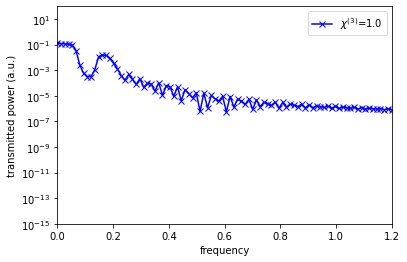

In [25]:
# practise from :
# https://meep.readthedocs.io/en/latest/Python_Tutorials/Third_Harmonic_Generation/

from typing import Tuple, List, Union
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import meep as mp
from meep.materials import Ag
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output, display, HTML,Image

mp.simulation.do_progress = False

nfreq = 100
amp = 1
sz = 100 # size of the cell in z direction
fcen =1/3 # center frequency of source
# df = fcen/10. # frequency width of source
# amp = amp # amplitude of source
k=1.00 # Kerr susceptibility
dpml = 1.0 # pml thickness
dimensions = 1 # one dimensional problem
cell = mp.Vector3(0,0,sz)
pml_layers = [mp.PML(dpml)]
resolution = 25
c=1

susceptibilities = [
    mp.LorentzianSusceptibility(frequency=0.1, gamma=1e-5, sigma=0.5),
    mp.LorentzianSusceptibility(frequency=0.5, gamma=0.1, sigma=2e-5),
]

def soliton_sol(x,t):
    return -.5*c/np.cosh(np.sqrt(c)/2*(x-c*t))**2

default_material = mp.Medium(index=1, chi3=k, E_susceptibilities=susceptibilities)

source_pos = -.5*sz+dpml


sources = [mp.Source(mp.CustomSource(src_func=lambda t: soliton_sol(-source_pos,t)),component=mp.Ex,center=mp.Vector3(0,0,source_pos), amplitude=amp)]
fmin = fcen / 2.0*0
fmax = fcen*4
# print(help(mp.materials))
sim = mp.Simulation(cell_size=cell,
                   sources=sources,
                   boundary_layers=pml_layers,
                   default_material=default_material,
                   resolution=resolution,
                   dimensions=dimensions)
mon_pt = mp.Vector3(0, 0, 0.5 * sz - dpml - 0.5)

trans = sim.add_flux( 0.5*(fmin+fmax), fmax-fmin, nfreq, mp.FluxRegion(mon_pt) )
sim.run(until=1)
ex_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ex)
z_ = np.linspace(0,sz,len(ex_data))

fig, ax = plt.subplots()
line, = ax.plot([])

ax.set_xlim(0,sz)
ax.set_ylim(-1.2,1.2)

def animate(frameNumber):
    ex_data = sim.get_array(center=mp.Vector3(), size=cell, component=mp.Ex)
    sim.run(until=3)
    line.set_data(z_,ex_data)
    clear_output()
    return line,

ax.set_xlabel("z")
ax.set_ylabel("Ex")

animation = FuncAnimation(fig, animate, frames=50, interval=50)

video = animation.to_html5_video()
display(HTML(video))
# animation.save('ex.gif')
# display(Image('ex.gif'))
plt.close()


# # sim.run( until_after_sources=mp.stop_when_fields_decayed(100, mp.Ex, mon_pt, 1e-3) )
sim.run(until=100)

freqs = mp.get_flux_freqs(trans)
trans_flux = mp.get_fluxes(trans)

fig, ax = plt.subplots()
ax.semilogy(freqs,trans_flux,'bx-',label=f'$\chi^{{(3)}}$={k}')
ax.set_xlabel('frequency')
ax.set_ylabel('transmitted power (a.u.)')
ax.set_xlim(0.0,1.2)
ax.set_ylim(1e-15,1e2)
ax.legend()
plt.show()